# ARSET CMS Flux Notebook using 'earthaccess' library with Integrated Data Download, Monthly Plotting, Monthly Average Difference Comparison, and Exported Image Files

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/moronidav/binders/0f9ace6829aba9dc41255af03a7ecbf2fd3ec601?urlpath=lab%2Ftree%2Farset-oco-earthaccess-download-analysis-2024-test-fluxes-4binder.ipynb)

**Summary:**

For demonstration and test purposes only. 

The target datasets in this notebook are the:
  1. **Carbon Monitoring System Carbon Flux NBE L4 V3 (CMSFluxNBE; DOI: 10.5067/TA1ED4IZFZ47)** from the NASA GES DISC; ([click here for details](https://disc.gsfc.nasa.gov/datasets/CMSFluxNBE_3/summary)).
  2. **Carbon Monitoring System Carbon Flux Ocean L4 V3 (CMSFluxOcean: DOI: 10.5067/9H6GCQKP28AI)** from the NASA GES DISC; ([click here for details](https://disc.gsfc.nasa.gov/datasets/CMSFluxOcean_3/summary)).
  3. **Carbon Monitoring System Carbon Flux FossilFuel Prior L4 V3 (CMSFluxFossilFuelPrior; DOI: 10.5067/Y7QUDGMD2HUG)** from the NASA GES DISC; ([click here for details](https://disc.gsfc.nasa.gov/datasets/CMSFluxFossilFuelPrior_3/summary)).

Before proceeding, an **Earthdata Login Account** ([click here to verify existing or create a new account](https://urs.earthdata.nasa.gov/users/new)) is required to execute this notebook. 

Once your **Earthdata Login Account** is verified, you will need to approve access to the **NASA GES DISC Archive** in your **Earthdata Login Profile** ([click here for instructions](https://disc.gsfc.nasa.gov/earthdata-login)).

**Optional:** A .netrc file containing individual **NASA Earthdata Login** credentials (not supplied with this notebook) may be provided by each user intending to operate this notebook locally or from within their preferred Jupyter environment. To create/modify a **.netrc** file, go to your home directory, create a new .netrc file (if not already present), and enter your **Earthdata Login** credentials on a new, empty line as shown below:
     <br>`machine urs.earthdata.nasa.gov login <your username> password <your password>`

**Other important notes:**

  1. Please "trust" this notebook before executing; this will prevent errors when writing output to your local directory.
  2. This notebook is only meant for initial training and demonstration of the utility of these datasets in support of the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET); for full details, please refer to: [https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related](https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related).
  3. This notebook is designed to function "as-is" for the scope of the training exercise; as code dependencies and data sources periodically become deprecated or updated, the users of these notebooks bear the responsibility to maintain and/or repurpose these notebooks and associated dependencies in a workable state beyond scope of initial training. 

## Notebook Author / Affiliation

David F. Moroni (david.f.moroni@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Date Authored

12 June 2024

### Date Last Modified

10 June 2025 - Refactored by David F. Moroni for Binder.

### Collaborators
  1. Karen Yuen (karen.yuen@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

  2. Junjie Liu (junjie.liu@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Acknowledgements

This notebook was produced to support the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET) training session. For full details, please refer to [https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related](https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related).

Passive contriutions were also incorporated via open-source Python code made available through the NASA/JPL TRopospheric Ozone and its Precursors from Earth System Sounding (TROPESS) Project, NASA Openscapes, the National Snow and Ice Data Center (NSIDC), and NASA's Goddard Earth Sciences Data and Information Services Center (GES DISC). 

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004). Government sponsorship acknowledged.

In [1]:
import os
import requests
import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()

import datetime
import contextlib

from pathlib import Path

import numpy as np
import netCDF4
from netCDF4 import Dataset

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

## Verify Successful Authentication to NASA Earthdata
### Prompt for NASA Earthdata Login Credentials (if .netrc file doesn't already exist)
### A .netrc file will be created if it doesn't already exist.

In [2]:
%%time
auth = earthaccess.login(strategy="interactive", persist=False)

# Optional: For users intending to download and run this notebook locally via static authentication using .netrc file (see comments in the 
# top Summary section), users may invoke the commented line below, and change the "persist" argument in the above line to "persist=True".
# auth.login(strategy="netrc")

authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

Authenication Valid = True
CPU times: user 83 ms, sys: 13.3 ms, total: 96.3 ms
Wall time: 5.17 s


## Now we will create the local output directory paths if they do not already exist.

In [3]:
%%time
data_dir_check = os.path.isdir('data')
print("Data directory exists: ",data_dir_check)

if data_dir_check != True: 
    os.makedirs('data')
    print("Created local data directory")

Data directory exists:  True
CPU times: user 551 µs, sys: 455 µs, total: 1.01 ms
Wall time: 643 µs


# Create a Function for CMR Catalog Requests

In [4]:
%%time
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


## Check that the CMR catalog can be accessed

If "200, CMR is accessible" is returned, the catalog can be accessed!

In [5]:
%%time
url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request to check that we can access CMR
response = cmr_request(url)

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible
CPU times: user 16 ms, sys: 4.04 ms, total: 20.1 ms
Wall time: 196 ms


## Specify netCDF Variable input parameters for the NBE Flux Data

In [6]:
# Define Measurement Variable Type; in this test case, we select 'xco2'.
measurement = 'NBE_post'

## Query CMR for the dataset shortname using the DOI (digital object identifier)

In [7]:
%%time
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.5067/TA1ED4IZFZ47'                   # CMS-flux NBE dataset DOI

doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

shortname = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
longname = requests.get(doisearch).json()['feed']['entry'][0]['dataset_id']
version_id = requests.get(doisearch).json()['feed']['entry'][0]['version_id']
print('Short Name = '+shortname)
print('Long Name = '+longname)
print('Version Identifier = '+version_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/TA1ED4IZFZ47
Short Name = CMSFluxNBE
Long Name = Carbon Monitoring System Carbon Flux NBE L4 V3 (CMSFluxNBE)
Version Identifier = 3
CPU times: user 42.4 ms, sys: 7.44 ms, total: 49.9 ms
Wall time: 440 ms


## Execute the CMR query for matching granules

In [8]:
%%time
# Define the start and end date/time (YYYY-MM-DD).
start_time = '2016-03-01'
end_time = '2016-03-31'

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id).temporal(start_time, end_time)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Granule hits: 1
CPU times: user 20.2 ms, sys: 3.83 ms, total: 24 ms
Wall time: 509 ms


[Collection: {'ShortName': 'CMSFluxNBE', 'Version': '3'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2010-01-01T00:00:00.000Z', 'EndingDateTime': '2022-12-31T23:59:59.000Z'}}
 Size(MB): 38.814144134521484
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/CMS/CMSFluxNBE.3/CMSFluxNBE201001_202212_v3.nc']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [9]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
    print("Downloaded file(s): ",files)
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")
    print("Downloaded file(s): ",files)

 Getting 1 granules, approx download size: 0.04 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Downloaded file(s):  ['data/CMSFluxNBE201001_202212_v3.nc']
CPU times: user 120 ms, sys: 151 ms, total: 271 ms
Wall time: 4.73 s


## Let's read the NBE flux data file. 

In [10]:
%%time

file = './'+files[0]

dataset = Dataset(f'{file}', 'r')
print("reading data from: ", file)

# Read the data from your variables
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
nbe_meas = dataset.variables[measurement][:]
time = dataset.variables['time']
area = dataset.variables['area'][:]

# Convert the time variable data into an np.array indicating the YYYY-MM-DDT00:00:00 information
nptime = np.array(netCDF4.num2date(time[:], units=time.units,calendar='360_day'),dtype='datetime64[s]')
dataset.close()

# Reshape 'area' array to be 3-D; to be used later in array multiplication with other 3-D array.
area = area.reshape((1, 180, 360))

# Recast the np.array 'nptime' to a 1-D string array
dtime = nptime.astype(str)

# Set the plotting/analysis limits for the latitude and longitude
latitude_max = 90.0
latitude_min = -90.0
longitude_max = 360.0
longitude_min = 0.0

reading data from:  ./data/CMSFluxNBE201001_202212_v3.nc
CPU times: user 34 ms, sys: 38.6 ms, total: 72.6 ms
Wall time: 72.5 ms


## Generate Lat/Lon Map NBE Flux Plot for March 2016

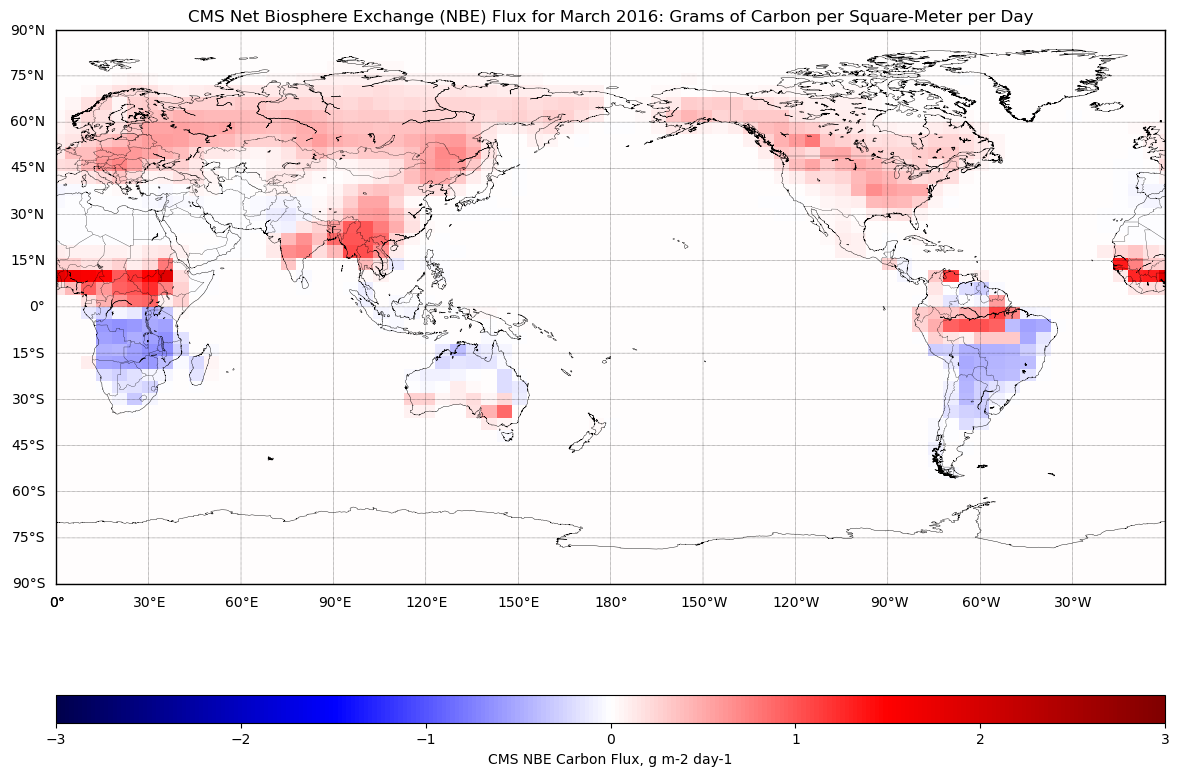

In [11]:
# Subset data to month/year
selection = np.where(dtime == '2016-03-15T00:00:00')[0]
index = selection[0]

nbe_meas_mar16 = nbe_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, nbe_meas_mar16, latlon=True, cmap='seismic', alpha=1.0, vmin=-3.0, vmax=3.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS NBE Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Net Biosphere Exchange (NBE) Flux for March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_nbe_flux_march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map NBE Flux Plot for July 2016

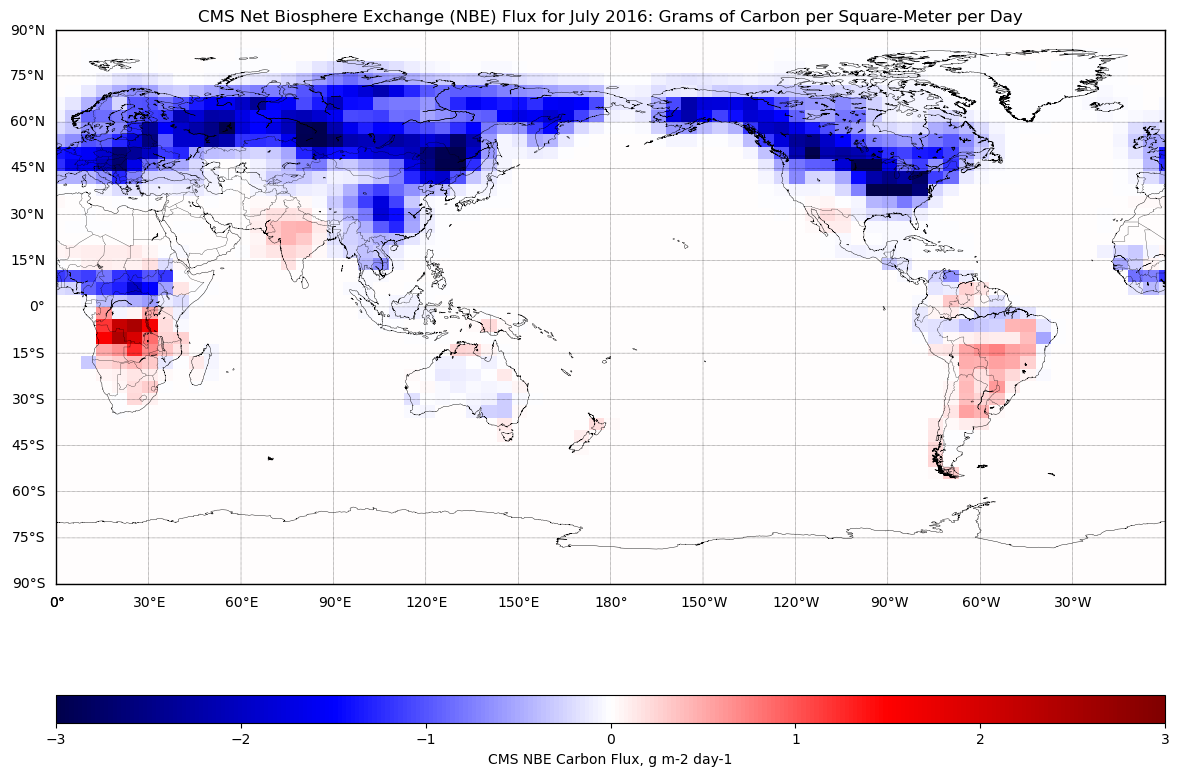

In [12]:
# Subset data to month/year
selection = np.where(dtime == '2016-07-15T00:00:00')[0]
index = selection[0]

nbe_meas_jul16 = nbe_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, nbe_meas_jul16, latlon=True, cmap='seismic', alpha=1.0, vmin=-3.0, vmax=3.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS NBE Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Net Biosphere Exchange (NBE) Flux for July 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_nbe_flux_july_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Plot the Lat/Lon Map Difference in NBE Flux for July-March 2016

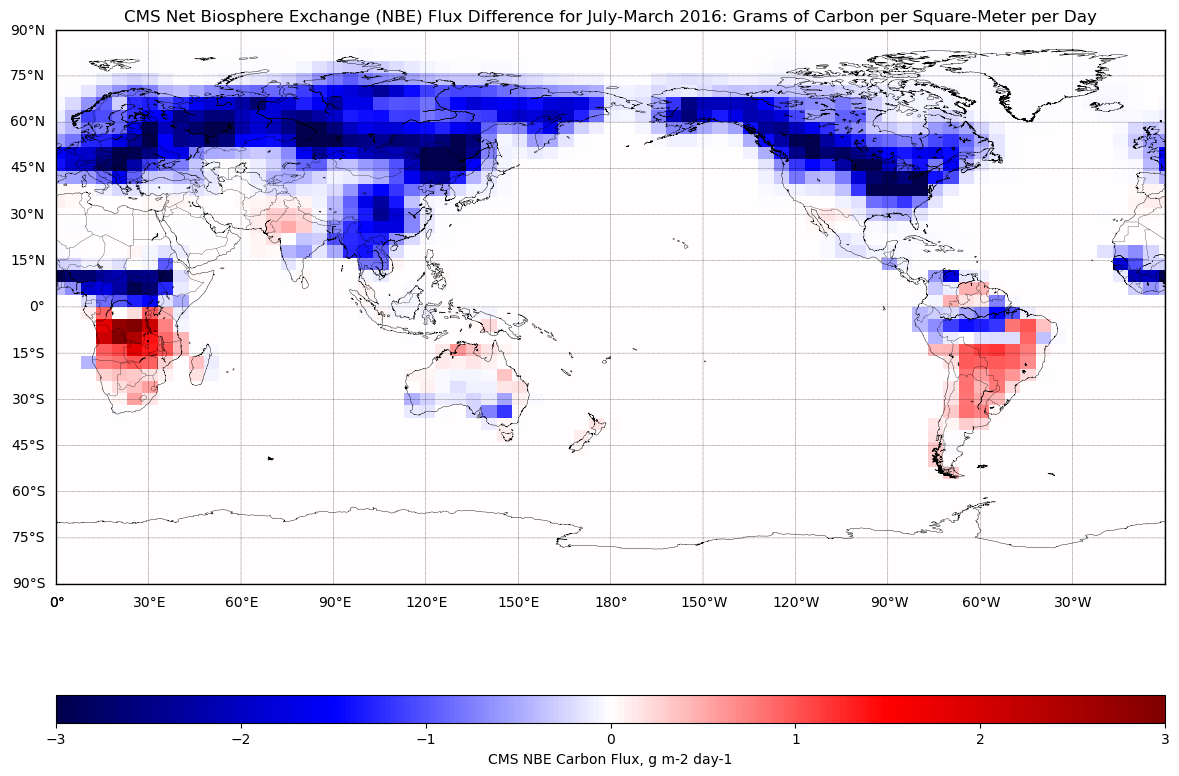

In [13]:
# Subset data to month/year
nbe_meas_diff = nbe_meas_jul16 - nbe_meas_mar16

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, nbe_meas_diff, latlon=True, cmap='seismic', alpha=1.0, vmin=-3.0, vmax=3.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%", ticks=[-3.0,-2.0,-1.0,0,1.0,2.0,3.0])
cbar.set_label('CMS NBE Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Net Biosphere Exchange (NBE) Flux Difference for July-March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_nbe_flux_diff_july-march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Prep for Annualized Totals

In [14]:
#Create new arrays allocated to store the number of days for each month; leap and non-leap years.
ndays=[31,28,31,30,31,30,31,31,30,31,30,31]
ndays_leap=[31,29,31,30,31,30,31,31,30,31,30,31]
ndays_apr15_mar16=[30,31,30,31,31,30,31,30,31,31,29,31]
ndays_apr16_mar17=[30,31,30,31,31,30,31,30,31,31,28,31]
months=[0,1,2,3,4,5,6,7,8,9,10,11]

## Generate Lat/Lon Map NBE Flux Totals Plot for April 2015 - March 2016

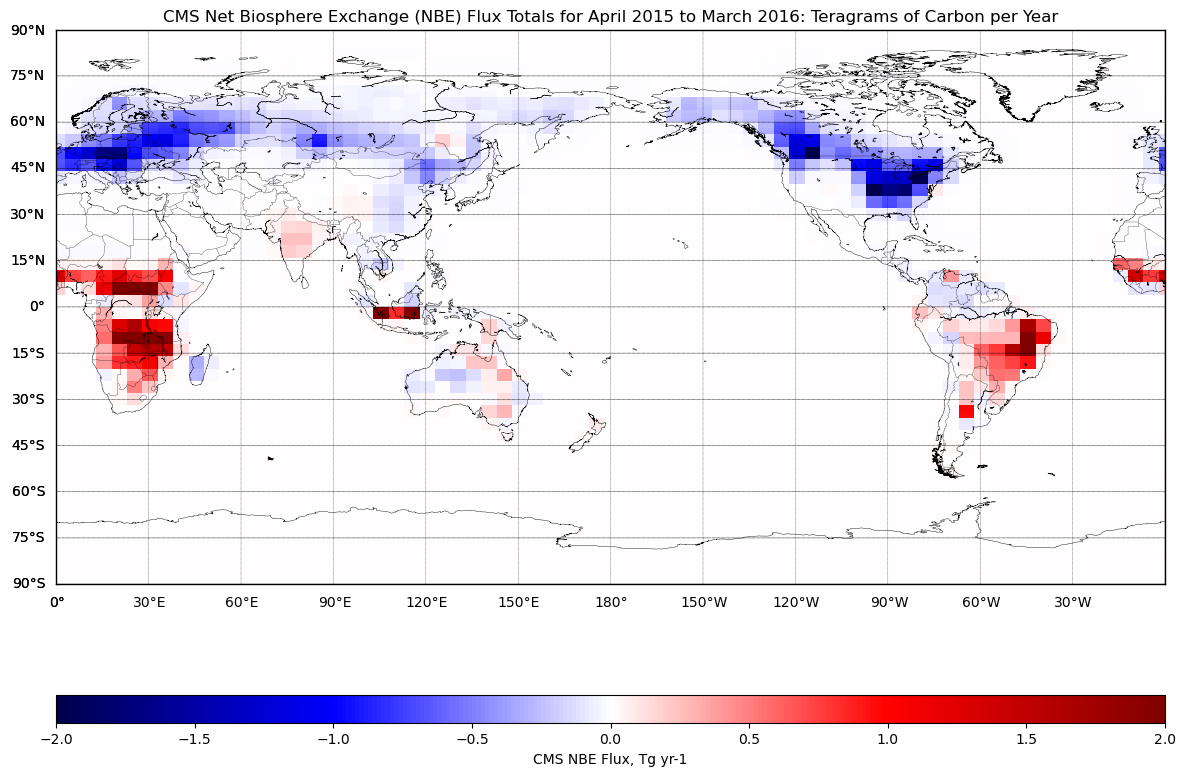

In [15]:
# Subset data to month/year
selection_start = np.where(dtime == '2015-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2016-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

nbe_meas_apr15_mar16 = nbe_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
nbe_meas_apr15_mar16_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted nbe
    nbe_meas_apr15_mar16_adj.append(nbe_meas_apr15_mar16[i,:,:]*area*ndays_apr15_mar16[i]*1.0e-12)

#Compute the total
nbe_meas_apr15_mar16_tot = np.sum(nbe_meas_apr15_mar16_adj, axis=0)

#Adjust array shape to 2-D
nbe_meas_apr15_mar16_tot = nbe_meas_apr15_mar16_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, nbe_meas_apr15_mar16_tot, latlon=True, cmap='seismic', alpha=1.0, vmin=-2.0, vmax=2.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS NBE Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Net Biosphere Exchange (NBE) Flux Totals for April 2015 to March 2016: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_nbe_flux_totals_april_2015_march_2016.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map NBE Flux Totals Plot for April 2016 - March 2017

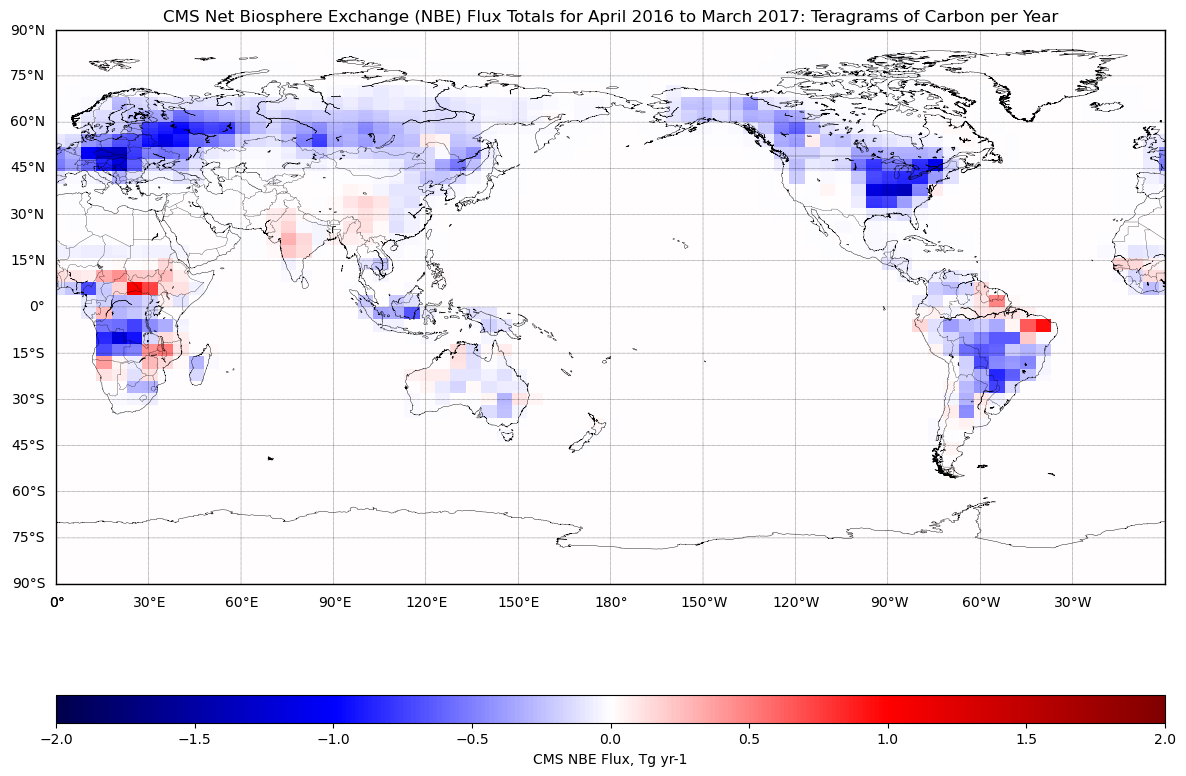

In [16]:
# Subset data to month/year
selection_start = np.where(dtime == '2016-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2017-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

nbe_meas_apr16_mar17 = nbe_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
nbe_meas_apr16_mar17_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted nbe
    nbe_meas_apr16_mar17_adj.append(nbe_meas_apr16_mar17[i,:,:]*area*ndays_apr16_mar17[i]*1.0e-12)

#Compute the total
nbe_meas_apr16_mar17_tot = np.sum(nbe_meas_apr16_mar17_adj, axis=0)

#Adjust array shape to 2-D
nbe_meas_apr16_mar17_tot = nbe_meas_apr16_mar17_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, nbe_meas_apr16_mar17_tot, latlon=True, cmap='seismic', alpha=1.0, vmin=-2.0, vmax=2.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS NBE Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Net Biosphere Exchange (NBE) Flux Totals for April 2016 to March 2017: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_nbe_flux_totals_april_2016_march_2017.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Specify netCDF Variable input parameters for the CMS-Flux Ocean Posterior Air-Sea Flux Data

In [17]:
# Define Measurement Variable Type; in this test case, we select 'xco2'.
measurement = 'ocean_post'

## Query CMR for the dataset shortname using the DOI (digital object identifier)

In [18]:
%%time
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.5067/9H6GCQKP28AI'                   # CMS-flux Ocean Posterior dataset DOI

doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

shortname = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
longname = requests.get(doisearch).json()['feed']['entry'][0]['dataset_id']
version_id = requests.get(doisearch).json()['feed']['entry'][0]['version_id']
print('Short Name = '+shortname)
print('Long Name = '+longname)
print('Version Identifier = '+version_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/9H6GCQKP28AI
Short Name = CMSFluxOcean
Long Name = Carbon Monitoring System Carbon Flux Ocean L4 V3 (CMSFluxOcean)
Version Identifier = 3
CPU times: user 42.1 ms, sys: 6.31 ms, total: 48.4 ms
Wall time: 571 ms


## Execute the CMR query for matching granules

In [19]:
%%time

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Granule hits: 1
CPU times: user 20.7 ms, sys: 4.38 ms, total: 25.1 ms
Wall time: 364 ms


[Collection: {'ShortName': 'CMSFluxOcean', 'Version': '3'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2010-01-01T00:00:00.000Z', 'EndingDateTime': '2022-12-31T23:59:59.000Z'}}
 Size(MB): 38.81416702270508
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/CMS/CMSFluxOcean.3/CMSFluxOcean201001_202212_v3.nc']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [20]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
    print("Downloaded file(s): ",files)
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")
    print("Downloaded file(s): ",files)

 Getting 1 granules, approx download size: 0.04 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Downloaded file(s):  ['data/CMSFluxOcean201001_202212_v3.nc']
CPU times: user 114 ms, sys: 141 ms, total: 255 ms
Wall time: 4.02 s


## Let's read the ocean posterior air-sea flux data file. 

In [21]:
%%time

file = './'+files[0]

dataset = Dataset(f'{file}', 'r')
print("reading data from: ", file)

# Read the data from your variables
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
airsea_meas = dataset.variables[measurement][:]
time = dataset.variables['time']
area = dataset.variables['area'][:]

# Convert the time variable data into an np.array indicating the YYYY-MM-DDT00:00:00 information
nptime = np.array(netCDF4.num2date(time[:], units=time.units,calendar='360_day'),dtype='datetime64[s]')
dataset.close()

# Reshape 'area' array to be 3-D; to be used later in array multiplication with other 3-D array.
area = area.reshape((1, 180, 360))

# Recast the np.array 'nptime' to a 1-D string array
dtime = nptime.astype(str)

# Set the plotting/analysis limits for the latitude and longitude
latitude_max = 90.0
latitude_min = -90.0
longitude_max = 360.0
longitude_min = 0.0

reading data from:  ./data/CMSFluxOcean201001_202212_v3.nc
CPU times: user 36.7 ms, sys: 31.1 ms, total: 67.8 ms
Wall time: 65.3 ms


## Generate Lat/Lon Map Air-Sea Carbon Flux Plot for March 2016

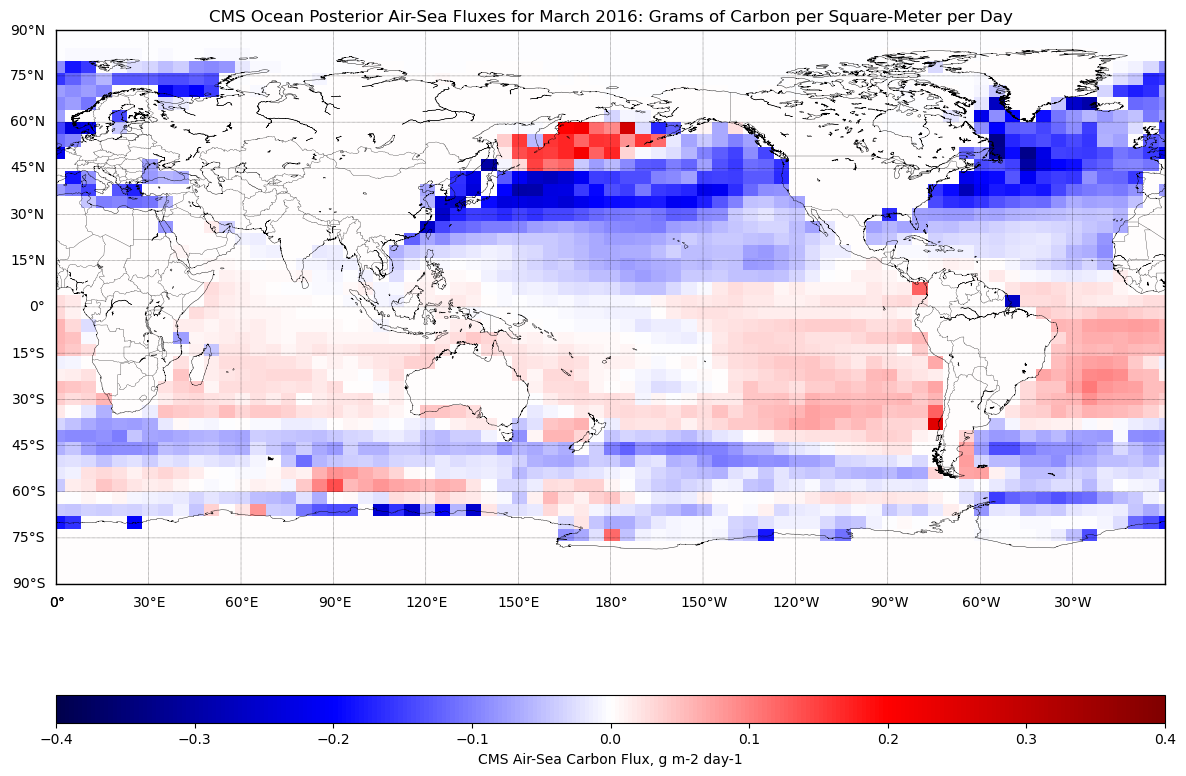

In [22]:
# Subset data to month/year
selection = np.where(dtime == '2016-03-15T00:00:00')[0]
index = selection[0]

airsea_meas_mar16 = airsea_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, airsea_meas_mar16, latlon=True, cmap='seismic', alpha=1.0, vmin=-0.4, vmax=0.4, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Air-Sea Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Ocean Posterior Air-Sea Fluxes for March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_ocean_posterior_fluxes_march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Air-Sea Carbon Flux Plot for July 2016

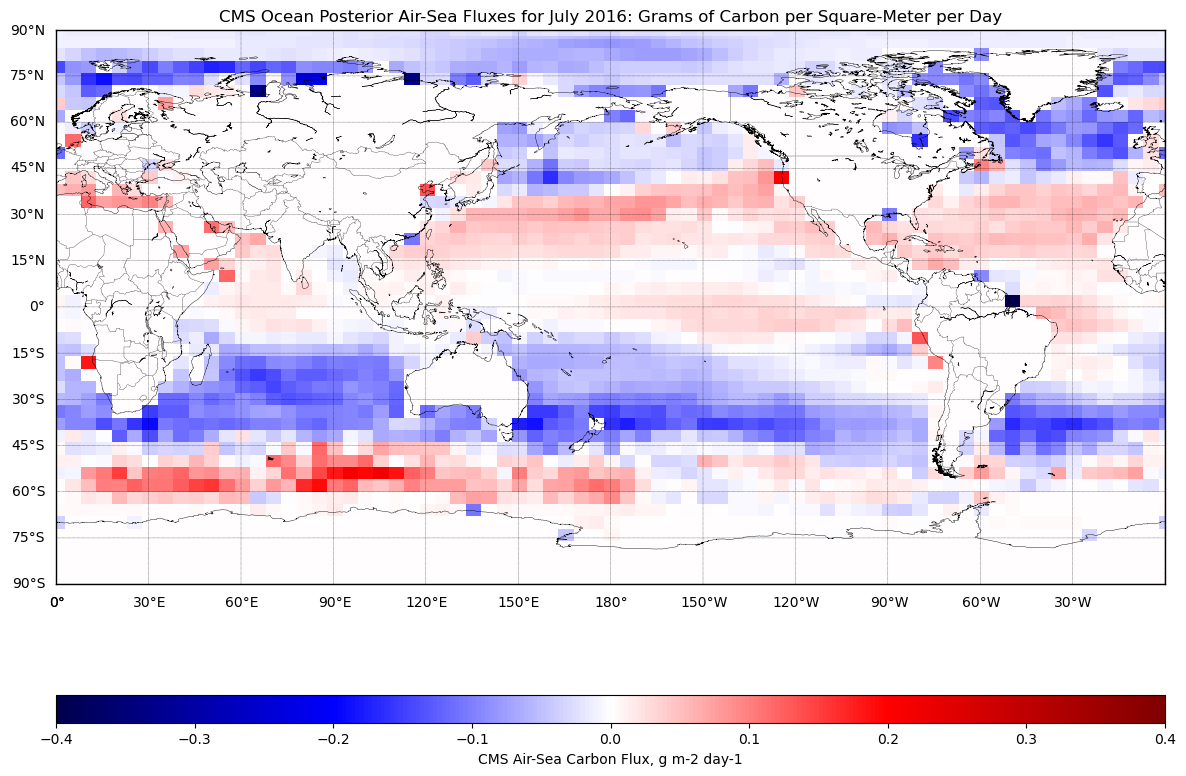

In [23]:
# Subset data to month/year
selection = np.where(dtime == '2016-07-15T00:00:00')[0]
index = selection[0]

airsea_meas_jul16 = airsea_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, airsea_meas_jul16, latlon=True, cmap='seismic', alpha=1.0, vmin=-0.4, vmax=0.4, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Air-Sea Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Ocean Posterior Air-Sea Fluxes for July 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_ocean_posterior_fluxes_july_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Plot the Lat/Lon Map Difference in Air-Sea Carbon Flux for July-March 2016

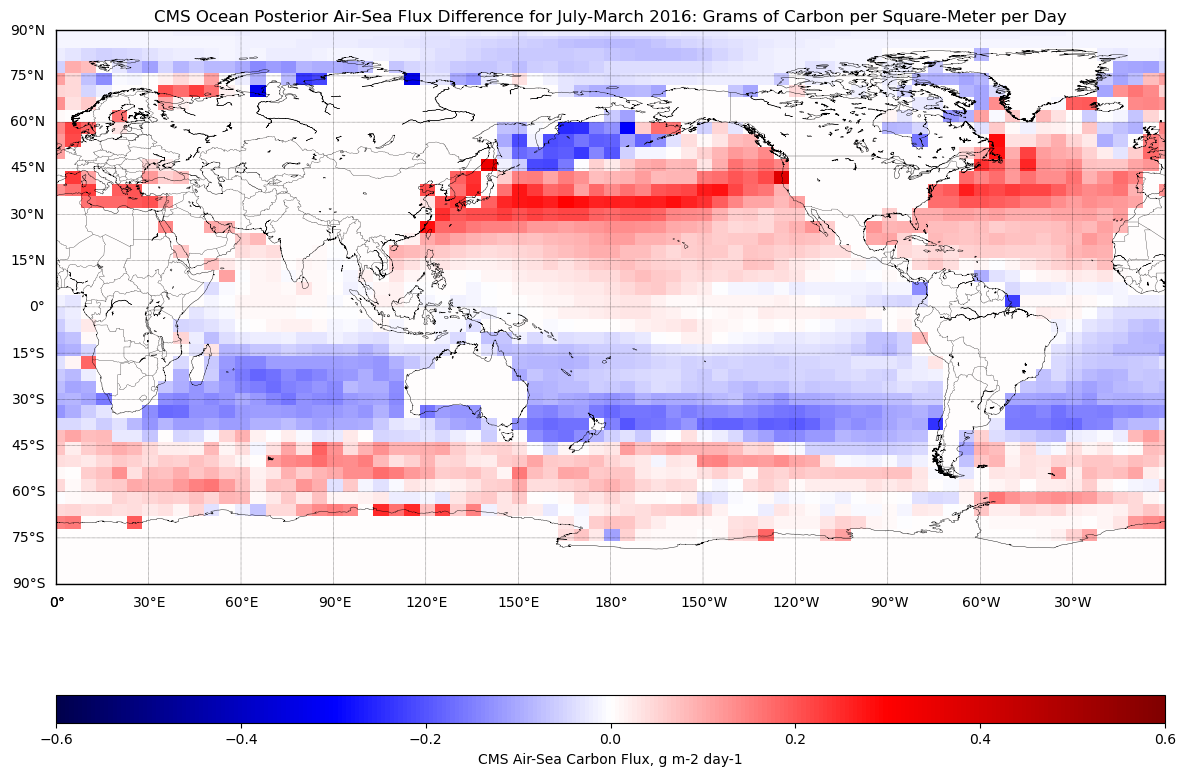

In [24]:
# Subset data to month/year
airsea_meas_diff = airsea_meas_jul16 - airsea_meas_mar16

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, airsea_meas_diff, latlon=True, cmap='seismic', alpha=1.0, vmin=-0.6, vmax=0.6, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%", ticks=[-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
cbar.set_label('CMS Air-Sea Carbon Flux, g m-2 day-1')

# set plot title
plt.title(f'CMS Ocean Posterior Air-Sea Flux Difference for July-March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_ocean_posterior_flux_diff_july-march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Air-Sea Carbon Flux Totals Plot for April 2015 - March 2016

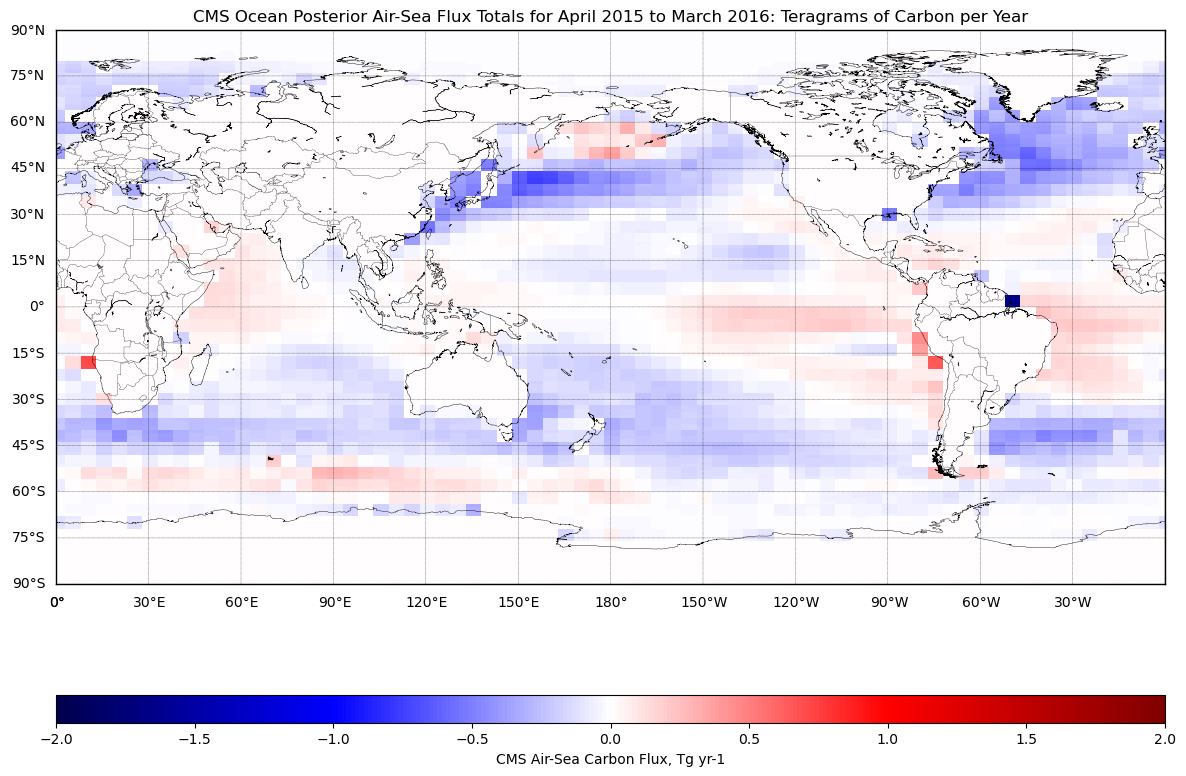

In [25]:
# Subset data to month/year
selection_start = np.where(dtime == '2015-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2016-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

airsea_meas_apr15_mar16 = airsea_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
airsea_meas_apr15_mar16_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted airsea
    airsea_meas_apr15_mar16_adj.append(airsea_meas_apr15_mar16[i,:,:]*area*ndays_apr15_mar16[i]*1.0e-12)

#Compute the total
airsea_meas_apr15_mar16_tot = np.sum(airsea_meas_apr15_mar16_adj, axis=0)

#Adjust array shape to 2-D
airsea_meas_apr15_mar16_tot = airsea_meas_apr15_mar16_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, airsea_meas_apr15_mar16_tot, latlon=True, cmap='seismic', alpha=1.0, vmin=-2.0, vmax=2.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Air-Sea Carbon Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Ocean Posterior Air-Sea Flux Totals for April 2015 to March 2016: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_ocean_posterior_flux_totals_april_2015_march_2016.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Air-Sea Carbon Flux Totals Plot for April 2016 - March 2017

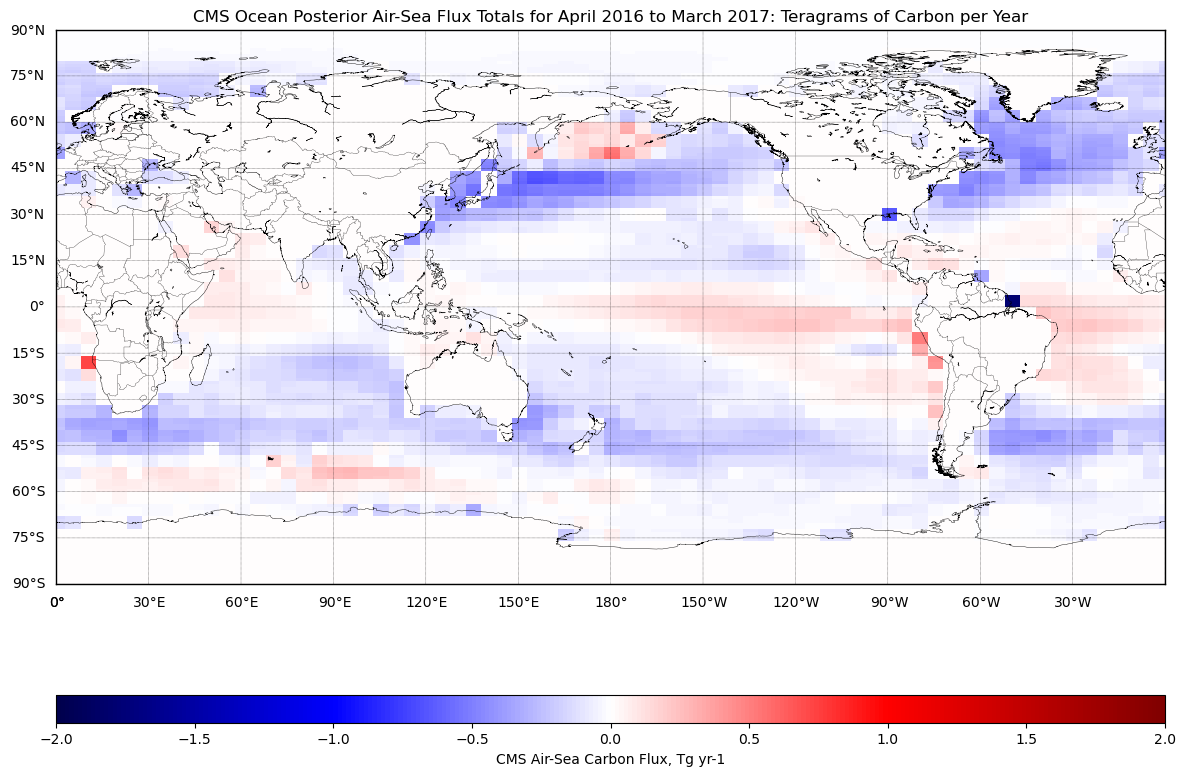

In [26]:
# Subset data to month/year
selection_start = np.where(dtime == '2016-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2017-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

airsea_meas_apr16_mar17 = airsea_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
airsea_meas_apr16_mar17_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted airsea
    airsea_meas_apr16_mar17_adj.append(airsea_meas_apr16_mar17[i,:,:]*area*ndays_apr16_mar17[i]*1.0e-12)

#Compute the total
airsea_meas_apr16_mar17_tot = np.sum(airsea_meas_apr16_mar17_adj, axis=0)

#Adjust array shape to 2-D
airsea_meas_apr16_mar17_tot = airsea_meas_apr16_mar17_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, airsea_meas_apr16_mar17_tot, latlon=True, cmap='seismic', alpha=1.0, vmin=-2.0, vmax=2.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Air-Sea Carbon Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Ocean Posterior Air-Sea Flux Totals for April 2016 to March 2017: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_ocean_posterior_flux_totals_april_2016_march_2017.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Specify netCDF Variable input parameters for the CMS-Flux Fossil Emission Data

In [27]:
# Define Measurement Variable Type; in this test case, we select 'xco2'.
measurement = 'fossil'

## Query CMR for the dataset shortname using the DOI (digital object identifier)

In [28]:
%%time
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.5067/Y7QUDGMD2HUG'                   # CMS-flux Fossil Emission dataset DOI

doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

shortname = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
longname = requests.get(doisearch).json()['feed']['entry'][0]['dataset_id']
version_id = requests.get(doisearch).json()['feed']['entry'][0]['version_id']
print('Short Name = '+shortname)
print('Long Name = '+longname)
print('Version Identifier = '+version_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/Y7QUDGMD2HUG
Short Name = CMSFluxFossilFuelPrior
Long Name = Carbon Monitoring System Carbon Flux FossilFuel Prior L4 V3 (CMSFluxFossilFuelPrior)
Version Identifier = 3
CPU times: user 43.5 ms, sys: 7.31 ms, total: 50.8 ms
Wall time: 565 ms


## Execute the CMR query for matching granules

In [29]:
%%time

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Granule hits: 1
CPU times: user 18.9 ms, sys: 3.81 ms, total: 22.7 ms
Wall time: 651 ms


[Collection: {'ShortName': 'CMSFluxFossilFuelPrior', 'Version': '3'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2010-01-01T00:00:00.000Z', 'EndingDateTime': '2022-12-31T23:59:59.000Z'}}
 Size(MB): 38.814208984375
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/CMS/CMSFluxFossilFuelPrior.3/CMSFluxFossilFuelPrior201001_202212_v3.nc']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [30]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
    print("Downloaded file(s): ",files)
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")
    print("Downloaded file(s): ",files)

 Getting 1 granules, approx download size: 0.04 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Downloaded file(s):  ['data/CMSFluxFossilFuelPrior201001_202212_v3.nc']
CPU times: user 108 ms, sys: 132 ms, total: 240 ms
Wall time: 4.22 s


## Let's read the fossil emission data file. 

In [31]:
%%time

file = './'+files[0]

dataset = Dataset(f'{file}', 'r')
print("reading data from: ", file)

# Read the data from your variables
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
fossil_meas = dataset.variables[measurement][:]
time = dataset.variables['time']
area = dataset.variables['area'][:]

# Convert the time variable data into an np.array indicating the YYYY-MM-DDT00:00:00 information
nptime = np.array(netCDF4.num2date(time[:], units=time.units,calendar='360_day'),dtype='datetime64[s]')
dataset.close()

# Reshape 'area' array to be 3-D; to be used later in array multiplication with other 3-D array.
area = area.reshape((1, 180, 360))

# Recast the np.array 'nptime' to a 1-D string array
dtime = nptime.astype(str)

# Set the plotting/analysis limits for the latitude and longitude
latitude_max = 90.0
latitude_min = -90.0
longitude_max = 360.0
longitude_min = 0.0

reading data from:  ./data/CMSFluxFossilFuelPrior201001_202212_v3.nc
CPU times: user 34.7 ms, sys: 30.5 ms, total: 65.2 ms
Wall time: 63.5 ms


## Generate Lat/Lon Map Fossil Emission Plot for March 2016

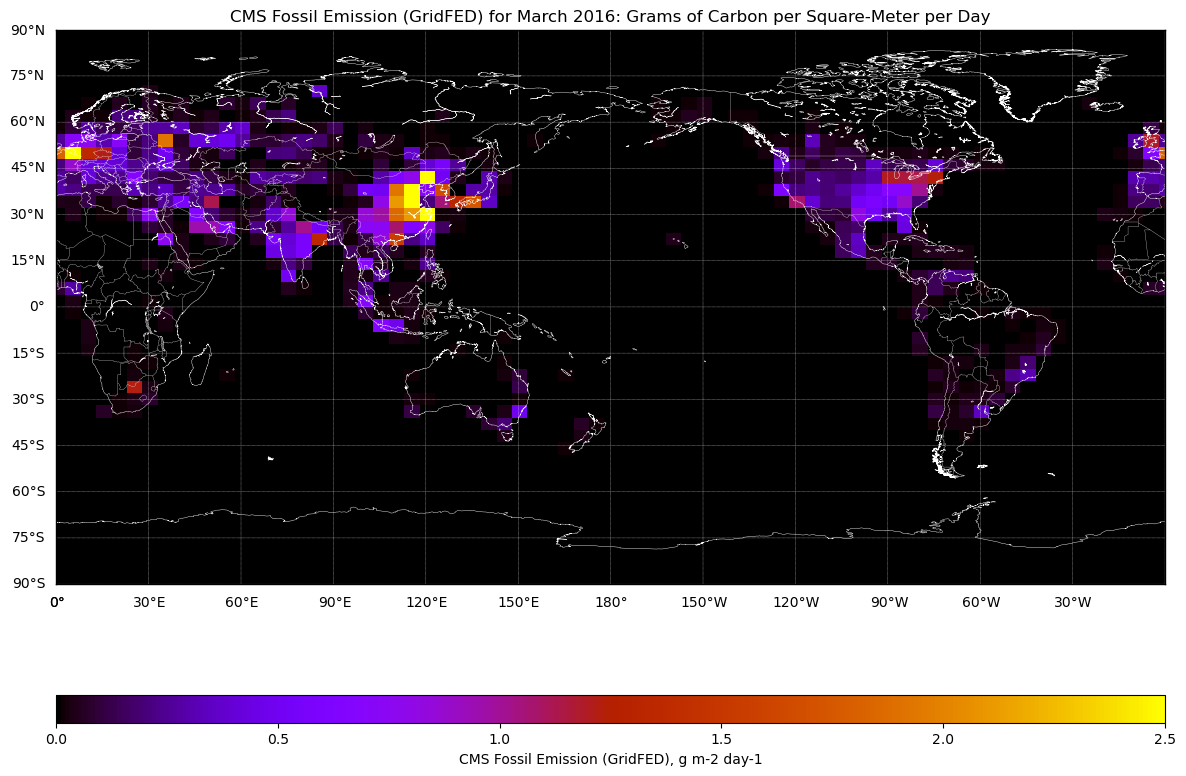

In [32]:
# Subset data to month/year
selection = np.where(dtime == '2016-03-15T00:00:00')[0]
index = selection[0]

fossil_meas_mar16 = fossil_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, fossil_meas_mar16, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.5, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Fossil Emission (GridFED), g m-2 day-1')

# set plot title
plt.title(f'CMS Fossil Emission (GridFED) for March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_fossil_emission_march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Fossil Emission Plot for July 2016

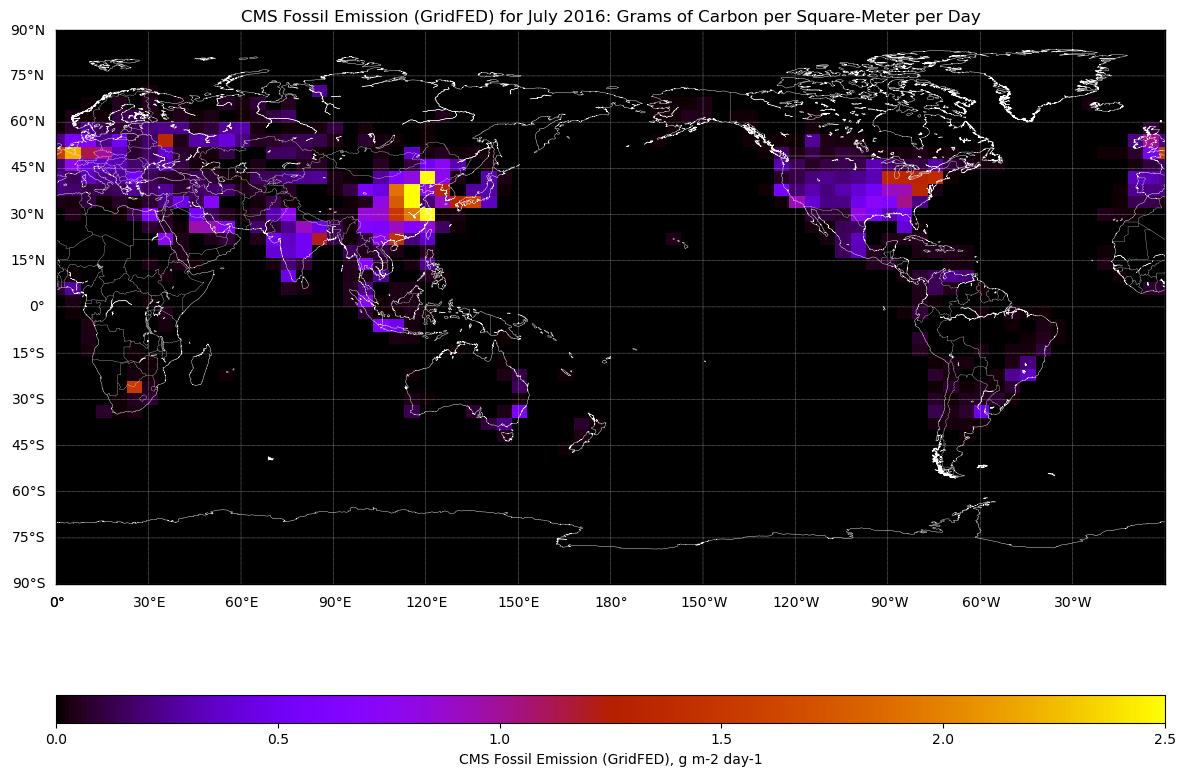

In [33]:
# Subset data to month/year
selection = np.where(dtime == '2016-07-15T00:00:00')[0]
index = selection[0]

fossil_meas_jul16 = fossil_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white') 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, fossil_meas_jul16, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.5, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Fossil Emission (GridFED), g m-2 day-1')

# set plot title
plt.title(f'CMS Fossil Emission (GridFED) for July 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_fossil_emission_july_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Plot the Lat/Lon Map Difference in Fossil Emission for July-March 2016

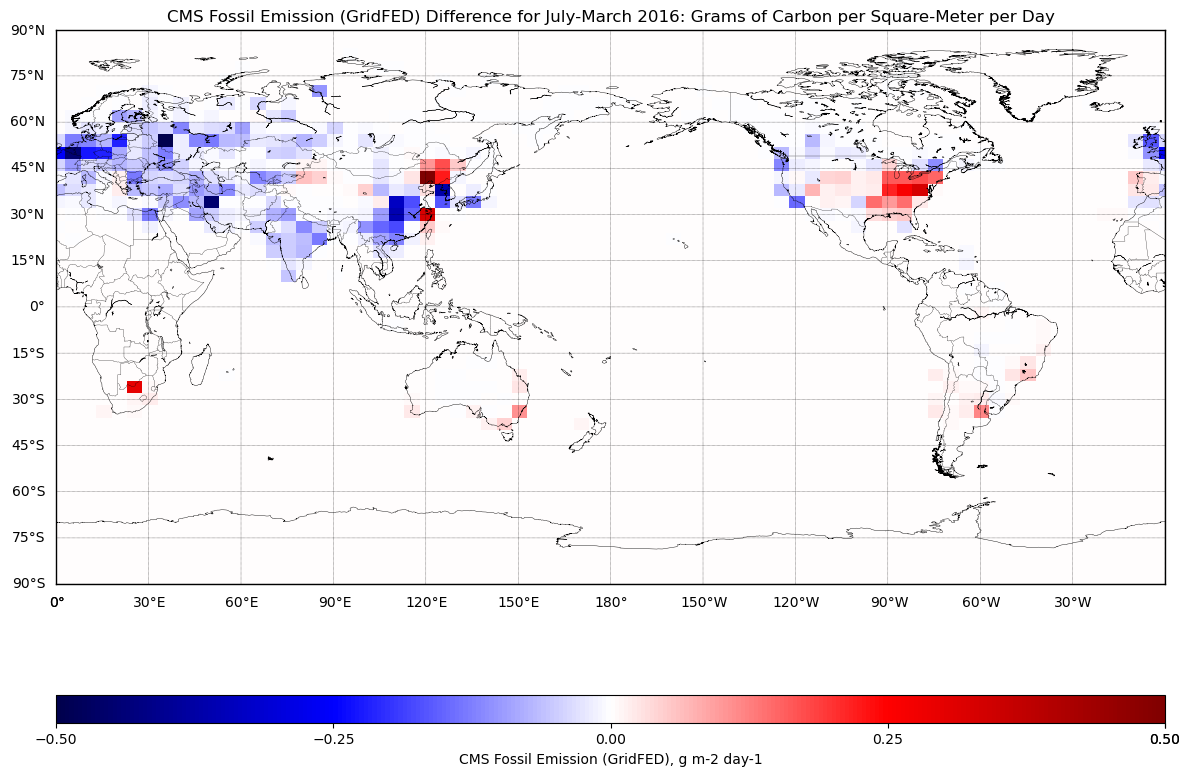

In [34]:
# Subset data to month/year
fossil_meas_diff = fossil_meas_jul16 - fossil_meas_mar16

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, fossil_meas_diff, latlon=True, cmap='seismic', alpha=1.0, vmin=-0.5, vmax=0.5, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%", ticks=[-0.5,-0.25,0,0.5,0.25,0.5])
cbar.set_label('CMS Fossil Emission (GridFED), g m-2 day-1')

# set plot title
plt.title(f'CMS Fossil Emission (GridFED) Difference for July-March 2016: Grams of Carbon per Square-Meter per Day')

# Save figure to PNG file
plt.savefig(f'./data/cms_fossil_emission_diff_july-march_2016_.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Fossil Emission Totals Plot for April 2015 - March 2016

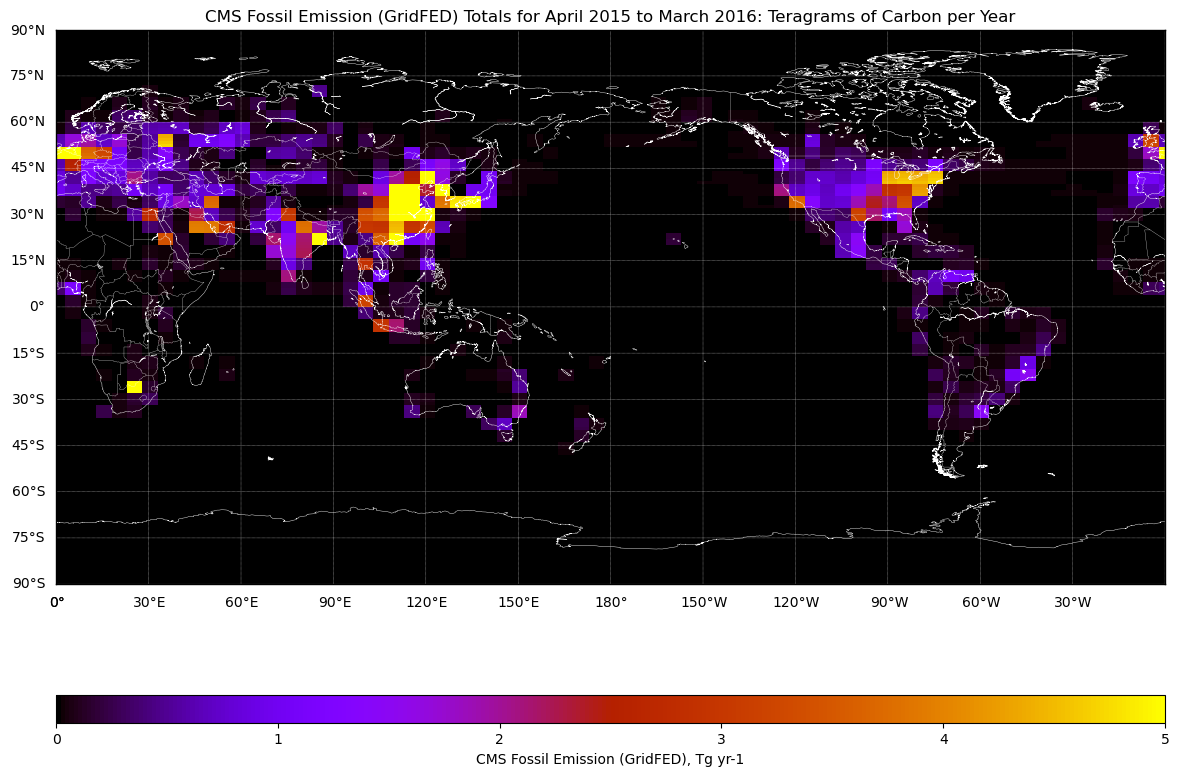

In [35]:
# Subset data to month/year
selection_start = np.where(dtime == '2015-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2016-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

fossil_meas_apr15_mar16 = fossil_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
fossil_meas_apr15_mar16_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted Fossil
    fossil_meas_apr15_mar16_adj.append(fossil_meas_apr15_mar16[i,:,:]*area*ndays_apr15_mar16[i]*1.0e-12)

#Compute the total
fossil_meas_apr15_mar16_tot = np.sum(fossil_meas_apr15_mar16_adj, axis=0)

#Adjust array shape to 2-D
fossil_meas_apr15_mar16_tot = fossil_meas_apr15_mar16_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white') 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, fossil_meas_apr15_mar16_tot, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=5.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Fossil Emission (GridFED), Tg yr-1')

# set plot title
plt.title(f'CMS Fossil Emission (GridFED) Totals for April 2015 to March 2016: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_fossil_emission_totals_april_2015_march_2016.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Fossil Emission Totals Plot for April 2016 - March 2017

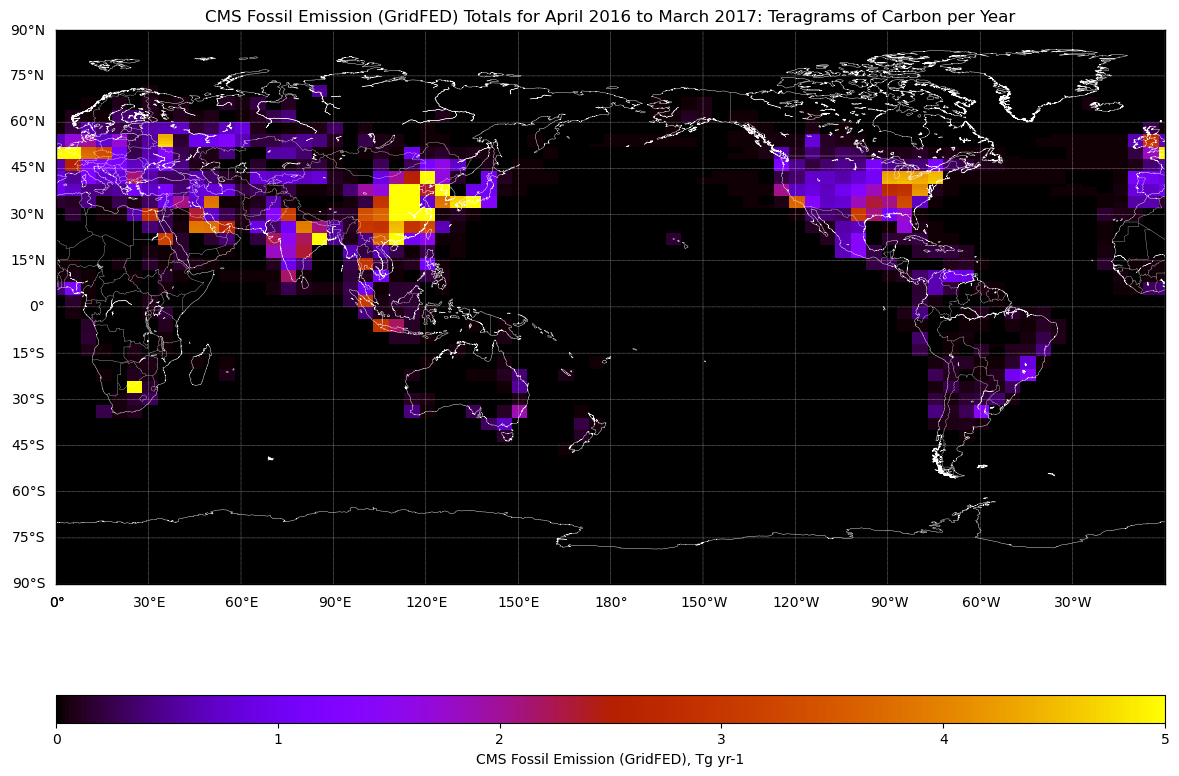

In [36]:
# Subset data to month/year
selection_start = np.where(dtime == '2016-04-15T00:00:00')[0]
selection_end = np.where(dtime == '2017-03-15T00:00:00')[0]
index_start = selection_start[0]
index_end = selection_end[0] +1

fossil_meas_apr16_mar17 = fossil_meas[index_start:index_end,:,:]

#Create new arrays to allocate the adjusted and total fluxes
fossil_meas_apr16_mar17_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted Fossil
    fossil_meas_apr16_mar17_adj.append(fossil_meas_apr16_mar17[i,:,:]*area*ndays_apr16_mar17[i]*1.0e-12)

#Compute the total
fossil_meas_apr16_mar17_tot = np.sum(fossil_meas_apr16_mar17_adj, axis=0)

#Adjust array shape to 2-D
fossil_meas_apr16_mar17_tot = fossil_meas_apr16_mar17_tot.reshape(180,360)

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white') 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, fossil_meas_apr16_mar17_tot, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=5.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Fossil Emission (GridFED), Tg yr-1')

# set plot title
plt.title(f'CMS Fossil Emission (GridFED) Totals for April 2016 to March 2017: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_fossil_emission_totals_april_2016_march_2017.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Total Net Carbon Flux Plot for April 2015 - March 2016

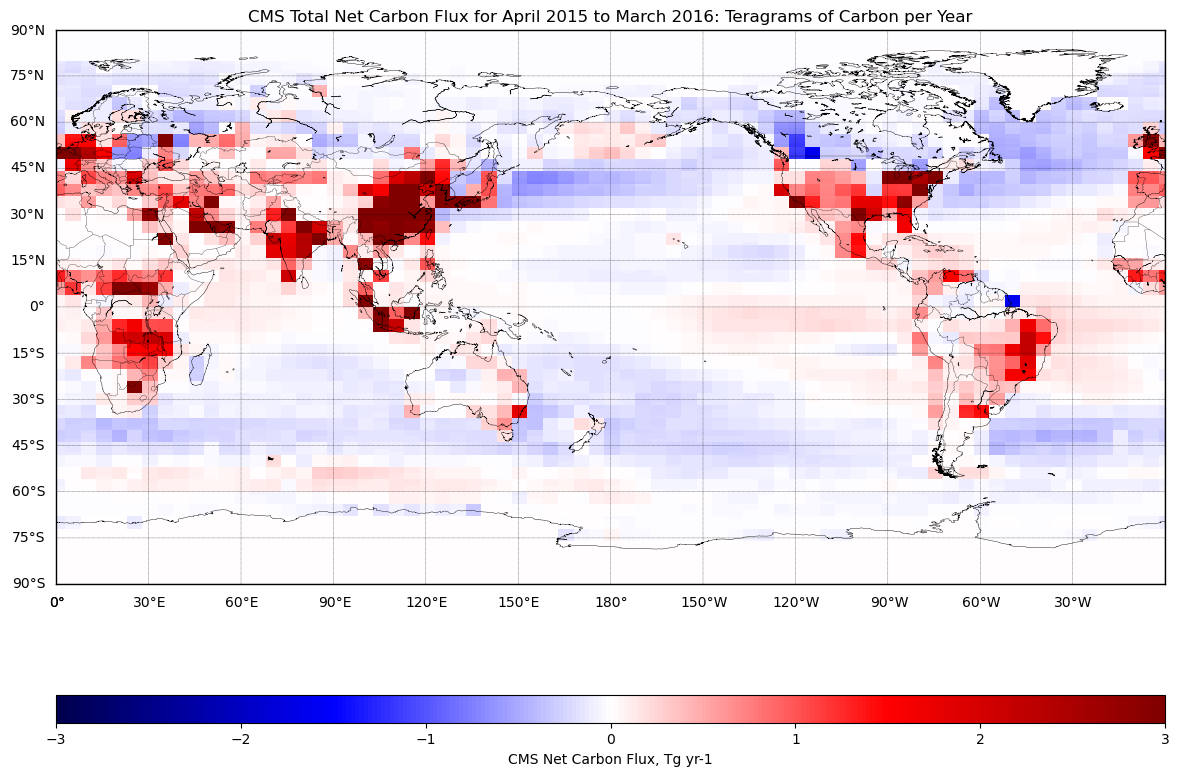

In [37]:
net_total_fluxes_apr2015_mar_2016 = fossil_meas_apr15_mar16_tot + airsea_meas_apr15_mar16_tot + nbe_meas_apr15_mar16_tot

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, net_total_fluxes_apr2015_mar_2016, latlon=True, cmap='seismic', alpha=1.0, vmin=-3.0, vmax=3.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Net Carbon Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Total Net Carbon Flux for April 2015 to March 2016: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_total_net_carbon_flux_april_2015_march_2016.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Generate Lat/Lon Map Total Net Carbon Flux Plot for April 2016 - March 2017

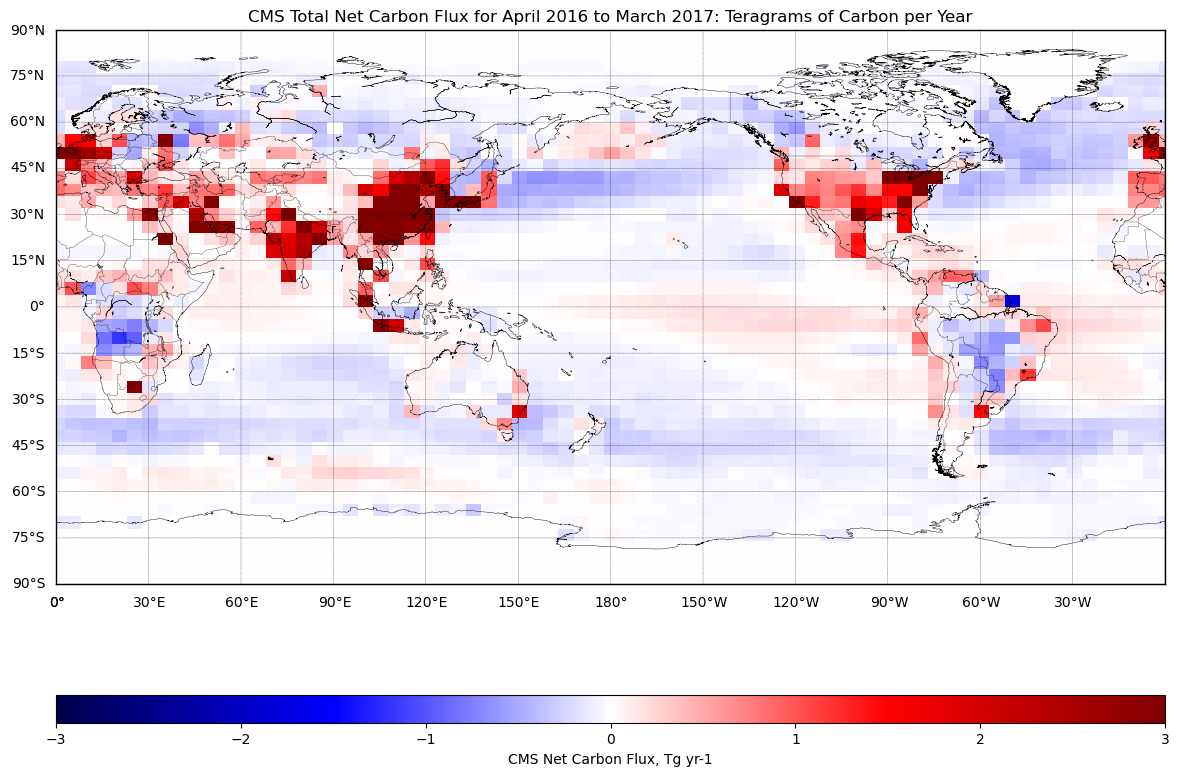

In [38]:
net_total_fluxes_apr2016_mar_2017 = fossil_meas_apr16_mar17_tot + airsea_meas_apr16_mar17_tot + nbe_meas_apr16_mar17_tot

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3) 
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, net_total_fluxes_apr2016_mar_2017, latlon=True, cmap='seismic', alpha=1.0, vmin=-3.0, vmax=3.0, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('CMS Net Carbon Flux, Tg yr-1')

# set plot title
plt.title(f'CMS Total Net Carbon Flux for April 2016 to March 2017: Teragrams of Carbon per Year')

# Save figure to PNG file
plt.savefig(f'./data/cms_total_net_carbon_flux_april_2016_march_2017.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

## Prepare Annual Total Flux Calculations

In [39]:
# Subset data to full-year records, from 2015 to 2022
start_yr_15 = np.where(dtime == '2015-01-15T00:00:00')[0]
end_yr_15 = np.where(dtime == '2015-12-15T00:00:00')[0]
i_start_15 = start_yr_15[0]
i_end_15 = end_yr_15[0]

start_yr_16 = np.where(dtime == '2016-01-15T00:00:00')[0]
end_yr_16 = np.where(dtime == '2016-12-15T00:00:00')[0]
i_start_16 = start_yr_16[0]
i_end_16 = end_yr_16[0]

start_yr_17 = np.where(dtime == '2017-01-15T00:00:00')[0]
end_yr_17 = np.where(dtime == '2017-12-15T00:00:00')[0]
i_start_17 = start_yr_17[0]
i_end_17 = end_yr_17[0]

start_yr_18 = np.where(dtime == '2018-01-15T00:00:00')[0]
end_yr_18 = np.where(dtime == '2018-12-15T00:00:00')[0]
i_start_18 = start_yr_18[0]
i_end_18 = end_yr_18[0]

start_yr_19 = np.where(dtime == '2019-01-15T00:00:00')[0]
end_yr_19 = np.where(dtime == '2019-12-15T00:00:00')[0]
i_start_19 = start_yr_19[0]
i_end_19 = end_yr_19[0]

start_yr_20 = np.where(dtime == '2020-01-15T00:00:00')[0]
end_yr_20 = np.where(dtime == '2020-12-15T00:00:00')[0]
i_start_20 = start_yr_20[0]
i_end_20 = end_yr_20[0]

start_yr_21 = np.where(dtime == '2021-01-15T00:00:00')[0]
end_yr_21 = np.where(dtime == '2021-12-15T00:00:00')[0]
i_start_21 = start_yr_21[0]
i_end_21 = end_yr_21[0]

start_yr_22 = np.where(dtime == '2022-01-15T00:00:00')[0]
end_yr_22 = np.where(dtime == '2022-12-15T00:00:00')[0]
i_start_22 = start_yr_22[0]
i_end_22 = end_yr_22[0]

#Store annually subsetted data into variable arrays
nbe_meas_2015 = nbe_meas[i_start_15:i_end_15+1,:,:]
nbe_meas_2016 = nbe_meas[i_start_16:i_end_16+1,:,:]
nbe_meas_2017 = nbe_meas[i_start_17:i_end_17+1,:,:]
nbe_meas_2018 = nbe_meas[i_start_18:i_end_18+1,:,:]
nbe_meas_2019 = nbe_meas[i_start_19:i_end_19+1,:,:]
nbe_meas_2020 = nbe_meas[i_start_20:i_end_20+1,:,:]
nbe_meas_2021 = nbe_meas[i_start_21:i_end_21+1,:,:]
nbe_meas_2022 = nbe_meas[i_start_22:i_end_22+1,:,:]

fossil_meas_2015 = fossil_meas[i_start_15:i_end_15+1,:,:]
fossil_meas_2016 = fossil_meas[i_start_16:i_end_16+1,:,:]
fossil_meas_2017 = fossil_meas[i_start_17:i_end_17+1,:,:]
fossil_meas_2018 = fossil_meas[i_start_18:i_end_18+1,:,:]
fossil_meas_2019 = fossil_meas[i_start_19:i_end_19+1,:,:]
fossil_meas_2020 = fossil_meas[i_start_20:i_end_20+1,:,:]
fossil_meas_2021 = fossil_meas[i_start_21:i_end_21+1,:,:]
fossil_meas_2022 = fossil_meas[i_start_22:i_end_22+1,:,:]

airsea_meas_2015 = airsea_meas[i_start_15:i_end_15+1,:,:]
airsea_meas_2016 = airsea_meas[i_start_16:i_end_16+1,:,:]
airsea_meas_2017 = airsea_meas[i_start_17:i_end_17+1,:,:]
airsea_meas_2018 = airsea_meas[i_start_18:i_end_18+1,:,:]
airsea_meas_2019 = airsea_meas[i_start_19:i_end_19+1,:,:]
airsea_meas_2020 = airsea_meas[i_start_20:i_end_20+1,:,:]
airsea_meas_2021 = airsea_meas[i_start_21:i_end_21+1,:,:]
airsea_meas_2022 = airsea_meas[i_start_22:i_end_22+1,:,:]

#Create new arrays to allocate the adjusted fluxes
nbe_meas_2015_adj=[]
nbe_meas_2016_adj=[]
nbe_meas_2017_adj=[]
nbe_meas_2018_adj=[]
nbe_meas_2019_adj=[]
nbe_meas_2020_adj=[]
nbe_meas_2021_adj=[]
nbe_meas_2022_adj=[]

airsea_meas_2015_adj=[]
airsea_meas_2016_adj=[]
airsea_meas_2017_adj=[]
airsea_meas_2018_adj=[]
airsea_meas_2019_adj=[]
airsea_meas_2020_adj=[]
airsea_meas_2021_adj=[]
airsea_meas_2022_adj=[]

fossil_meas_2015_adj=[]
fossil_meas_2016_adj=[]
fossil_meas_2017_adj=[]
fossil_meas_2018_adj=[]
fossil_meas_2019_adj=[]
fossil_meas_2020_adj=[]
fossil_meas_2021_adj=[]
fossil_meas_2022_adj=[]

# For all years, adjusted for area and days per month
for i in months:

    #Adjusted NBE
    nbe_meas_2015_adj.append(nbe_meas_2015[i,:,:]*area*ndays[i]*1.0e-15)
    nbe_meas_2017_adj.append(nbe_meas_2017[i,:,:]*area*ndays[i]*1.0e-15)
    nbe_meas_2018_adj.append(nbe_meas_2018[i,:,:]*area*ndays[i]*1.0e-15)
    nbe_meas_2019_adj.append(nbe_meas_2019[i,:,:]*area*ndays[i]*1.0e-15)
    nbe_meas_2021_adj.append(nbe_meas_2021[i,:,:]*area*ndays[i]*1.0e-15)
    nbe_meas_2022_adj.append(nbe_meas_2022[i,:,:]*area*ndays[i]*1.0e-15)

    #Adjusted airsea
    airsea_meas_2015_adj.append(airsea_meas_2015[i,:,:]*area*ndays[i]*1.0e-15)
    airsea_meas_2017_adj.append(airsea_meas_2017[i,:,:]*area*ndays[i]*1.0e-15)
    airsea_meas_2018_adj.append(airsea_meas_2018[i,:,:]*area*ndays[i]*1.0e-15)
    airsea_meas_2019_adj.append(airsea_meas_2019[i,:,:]*area*ndays[i]*1.0e-15)
    airsea_meas_2021_adj.append(airsea_meas_2021[i,:,:]*area*ndays[i]*1.0e-15)
    airsea_meas_2022_adj.append(airsea_meas_2022[i,:,:]*area*ndays[i]*1.0e-15)

    #Adjusted fossil
    fossil_meas_2015_adj.append(fossil_meas_2015[i,:,:]*area*ndays[i]*1.0e-15)
    fossil_meas_2017_adj.append(fossil_meas_2017[i,:,:]*area*ndays[i]*1.0e-15)
    fossil_meas_2018_adj.append(fossil_meas_2018[i,:,:]*area*ndays[i]*1.0e-15)
    fossil_meas_2019_adj.append(fossil_meas_2019[i,:,:]*area*ndays[i]*1.0e-15)
    fossil_meas_2021_adj.append(fossil_meas_2021[i,:,:]*area*ndays[i]*1.0e-15)
    fossil_meas_2022_adj.append(fossil_meas_2022[i,:,:]*area*ndays[i]*1.0e-15)

# For leap years, adjusted for area and days per month
for i in months:

    #Adjusted NBE
    nbe_meas_2016_adj.append(nbe_meas_2016[i,:,:]*area*ndays_leap[i]*1.0e-15)
    nbe_meas_2020_adj.append(nbe_meas_2020[i,:,:]*area*ndays_leap[i]*1.0e-15)

    #Adjusted airsea
    airsea_meas_2016_adj.append(airsea_meas_2016[i,:,:]*area*ndays_leap[i]*1.0e-15)
    airsea_meas_2020_adj.append(airsea_meas_2020[i,:,:]*area*ndays_leap[i]*1.0e-15)

    #Adjusted fossil
    fossil_meas_2016_adj.append(fossil_meas_2016[i,:,:]*area*ndays_leap[i]*1.0e-15)
    fossil_meas_2020_adj.append(fossil_meas_2020[i,:,:]*area*ndays_leap[i]*1.0e-15)
    
#Compute NBE flux totals into a single value for each year
nbe_tot_2015 = np.sum(nbe_meas_2015_adj)
print("NBE Total Flux for 2015 = ",nbe_tot_2015)

nbe_tot_2016 = np.sum(nbe_meas_2016_adj)
print("NBE Total Flux for 2016 = ",nbe_tot_2016)

nbe_tot_2017 = np.sum(nbe_meas_2017_adj)
print("NBE Total Flux for 2017 = ",nbe_tot_2017)

nbe_tot_2018 = np.sum(nbe_meas_2018_adj)
print("NBE Total Flux for 2018 = ",nbe_tot_2018)

nbe_tot_2019 = np.sum(nbe_meas_2019_adj)
print("NBE Total Flux for 2019 = ",nbe_tot_2019)

nbe_tot_2020 = np.sum(nbe_meas_2020_adj)
print("NBE Total Flux for 2020 = ",nbe_tot_2020)

nbe_tot_2021 = np.sum(nbe_meas_2021_adj)
print("NBE Total Flux for 2021 = ",nbe_tot_2021)

nbe_tot_2022 = np.sum(nbe_meas_2022_adj)
print("NBE Total Flux for 2022 = ",nbe_tot_2022)

print("-----------")

#Compute Air-Sea flux totals, adjusted for area/days/months, into a single value for each year
airsea_tot_2015 = np.sum(airsea_meas_2015_adj)
print("airsea Total Flux for 2015 = ",airsea_tot_2015)

airsea_tot_2016 = np.sum(airsea_meas_2016_adj)
print("airsea Total Flux for 2016 = ",airsea_tot_2016)

airsea_tot_2017 = np.sum(airsea_meas_2017_adj)
print("airsea Total Flux for 2017 = ",airsea_tot_2017)

airsea_tot_2018 = np.sum(airsea_meas_2018_adj)
print("airsea Total Flux for 2018 = ",airsea_tot_2018)

airsea_tot_2019 = np.sum(airsea_meas_2019_adj)
print("airsea Total Flux for 2019 = ",airsea_tot_2019)

airsea_tot_2020 = np.sum(airsea_meas_2020_adj)
print("airsea Total Flux for 2020 = ",airsea_tot_2020)

airsea_tot_2021 = np.sum(airsea_meas_2021_adj)
print("airsea Total Flux for 2021 = ",airsea_tot_2021)

airsea_tot_2022 = np.sum(airsea_meas_2022_adj)
print("airsea Total Flux for 2022 = ",airsea_tot_2022)

print("-----------")

#Compute Fossil flux totals, adjusted for area/days/months, into a single value for each year
fossil_tot_2015 = np.sum(fossil_meas_2015_adj)
print("fossil Total Flux for 2015 = ",fossil_tot_2015)

fossil_tot_2016 = np.sum(fossil_meas_2016_adj)
print("fossil Total Flux for 2016 = ",fossil_tot_2016)

fossil_tot_2017 = np.sum(fossil_meas_2017_adj)
print("fossil Total Flux for 2017 = ",fossil_tot_2017)

fossil_tot_2018 = np.sum(fossil_meas_2018_adj)
print("fossil Total Flux for 2018 = ",fossil_tot_2018)

fossil_tot_2019 = np.sum(fossil_meas_2019_adj)
print("fossil Total Flux for 2019 = ",fossil_tot_2019)

fossil_tot_2020 = np.sum(fossil_meas_2020_adj)
print("fossil Total Flux for 2020 = ",fossil_tot_2020)

fossil_tot_2021 = np.sum(fossil_meas_2021_adj)
print("fossil Total Flux for 2021 = ",fossil_tot_2021)

fossil_tot_2022 = np.sum(fossil_meas_2022_adj)
print("fossil Total Flux for 2022 = ",fossil_tot_2022)

print("-----------")

#Compute Aggregated flux totals into a single value for each year
tot_2015 = fossil_tot_2015+airsea_tot_2015+nbe_tot_2015
print("Total Flux for 2015 = ",tot_2015)

tot_2016 = fossil_tot_2016+airsea_tot_2016+nbe_tot_2016
print("Total Flux for 2016 = ",tot_2016)

tot_2017 = fossil_tot_2017+airsea_tot_2017+nbe_tot_2017
print("Total Flux for 2017 = ",tot_2017)

tot_2018 = fossil_tot_2018+airsea_tot_2018+nbe_tot_2018
print("Total Flux for 2018 = ",tot_2018)

tot_2019 = fossil_tot_2019+airsea_tot_2019+nbe_tot_2019
print("Total Flux for 2019 = ",tot_2019)

tot_2020 = fossil_tot_2020+airsea_tot_2020+nbe_tot_2020
print("Total Flux for 2020 = ",tot_2020)

tot_2021 = fossil_tot_2021+airsea_tot_2021+nbe_tot_2021
print("Total Flux for 2021 = ",tot_2021)

tot_2022 = fossil_tot_2022+airsea_tot_2022+nbe_tot_2022
print("Total Flux for 2022 = ",tot_2022)

NBE Total Flux for 2015 =  -1.0208458
NBE Total Flux for 2016 =  -0.7777791
NBE Total Flux for 2017 =  -2.288038
NBE Total Flux for 2018 =  -2.8559535
NBE Total Flux for 2019 =  -2.4498103
NBE Total Flux for 2020 =  -1.6158068
NBE Total Flux for 2021 =  -2.1936994
NBE Total Flux for 2022 =  -3.6700525
-----------
airsea Total Flux for 2015 =  -2.5575376
airsea Total Flux for 2016 =  -2.6472225
airsea Total Flux for 2017 =  -2.500952
airsea Total Flux for 2018 =  -2.4330423
airsea Total Flux for 2019 =  -2.4302762
airsea Total Flux for 2020 =  -2.5882385
airsea Total Flux for 2021 =  -2.391047
airsea Total Flux for 2022 =  -2.44763
-----------
fossil Total Flux for 2015 =  9.501196
fossil Total Flux for 2016 =  9.48548
fossil Total Flux for 2017 =  9.629092
fossil Total Flux for 2018 =  9.8208275
fossil Total Flux for 2019 =  9.897814
fossil Total Flux for 2020 =  9.455373
fossil Total Flux for 2021 =  9.91921
fossil Total Flux for 2022 =  9.933025
-----------
Total Flux for 2015 =  5.9

## Plot and Compare the Annual Total Fluxes in Bar Chart

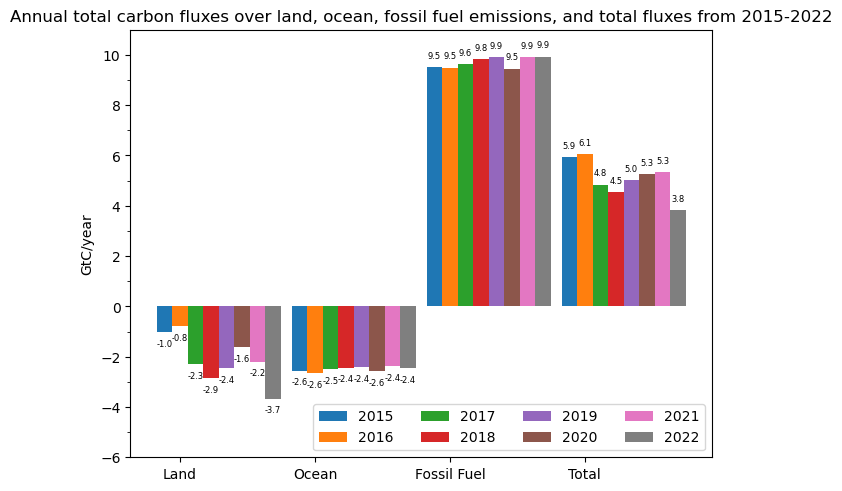

In [40]:
# Define the bar chart groups and the flux totals data
bar_groups = ("Land", "Ocean", "Fossil Fuel", "Total")
flux_totals = {
    '2015': (nbe_tot_2015,airsea_tot_2015,fossil_tot_2015,tot_2015),
    '2016': (nbe_tot_2016,airsea_tot_2016,fossil_tot_2016,tot_2016),
    '2017': (nbe_tot_2017,airsea_tot_2017,fossil_tot_2017,tot_2017),
    '2018': (nbe_tot_2018,airsea_tot_2018,fossil_tot_2018,tot_2018),    
    '2019': (nbe_tot_2019,airsea_tot_2019,fossil_tot_2019,tot_2019),    
    '2020': (nbe_tot_2020,airsea_tot_2020,fossil_tot_2020,tot_2020),    
    '2021': (nbe_tot_2021,airsea_tot_2021,fossil_tot_2021,tot_2021),
    '2022': (nbe_tot_2022,airsea_tot_2022,fossil_tot_2022,tot_2022)
}

x = np.arange(len(bar_groups))  # the label locations
width = 0.115  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in flux_totals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt='%.1f', padding=5, size=6)
    multiplier += 1.0

# Format the text for labels, title and custom x-axis tick labels, etc.
ticks=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
ax.set_ylabel('GtC/year')
ax.set_title('Annual total carbon fluxes over land, ocean, fossil fuel emissions, and total fluxes from 2015-2022')
ax.set_xticks(x + width, bar_groups)
ax.set_yticks(ticks, minor=True)
ax.legend(loc='lower right', ncols=4)
ax.set_ylim(-6, 11)

# Save figure to PNG file
plt.savefig(f'./data/annual_total_carbon_fluxes_2015_2022.png', dpi=dpi, bbox_inches='tight')
plt.show()
plt.close()

## Compute the 2015-2022 Global Mean Carbon Fluxes

In [41]:
# Construct arrays containing totals, then compute the means
nbe_totals = [nbe_tot_2015,nbe_tot_2016,nbe_tot_2017,nbe_tot_2018,nbe_tot_2019,nbe_tot_2020,nbe_tot_2021,nbe_tot_2022]
mean_nbe = np.mean(nbe_totals)
print("2015-2022 Global Mean NBE Flux = ",mean_nbe)

airsea_totals = [airsea_tot_2015,airsea_tot_2016,airsea_tot_2017,airsea_tot_2018,airsea_tot_2019,airsea_tot_2020,airsea_tot_2021,airsea_tot_2022]
mean_airsea = np.mean(airsea_totals)
print("2015-2022 Global Mean AirSea Flux = ",mean_airsea)

fossil_totals = [fossil_tot_2015,fossil_tot_2016,fossil_tot_2017,fossil_tot_2018,fossil_tot_2019,fossil_tot_2020,fossil_tot_2021,fossil_tot_2022]
mean_fossil = np.mean(fossil_totals)
print("2015-2022 Global Mean Fossil Fuel Flux = ",mean_fossil)

flux_tot = [tot_2015,tot_2016,tot_2017,tot_2018,tot_2019,tot_2020,tot_2021,tot_2022]
mean_tot = np.mean(flux_tot)
print("2015-2022 Total Mean Carbon Flux = ",mean_tot)

2015-2022 Global Mean NBE Flux =  -2.1089983
2015-2022 Global Mean AirSea Flux =  -2.4994931
2015-2022 Global Mean Fossil Fuel Flux =  9.705252
2015-2022 Total Mean Carbon Flux =  5.0967607


## Compute and Plot the Annual Global Flux Anomalies relative to the 2015-2022 Global Mean Fluxes

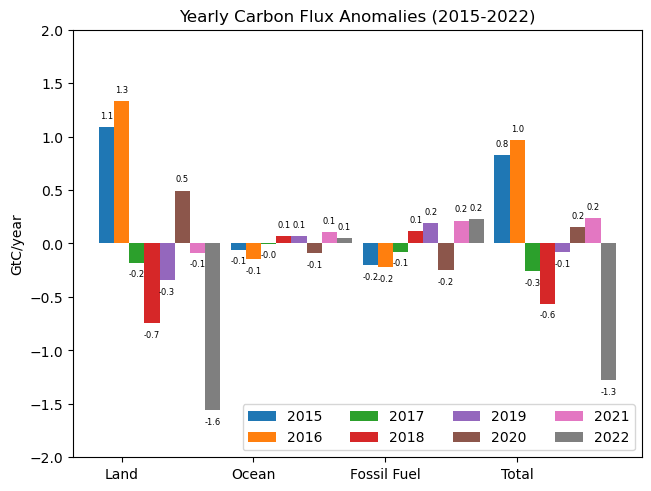

In [42]:
# Compute the anomalies as arrays [2015 - 2022] for NBE, AirSea, and Fossil
nbe_anom = nbe_totals - mean_nbe
airsea_anom = airsea_totals - mean_airsea
fossil_anom = fossil_totals - mean_fossil
tot_anom = flux_tot - mean_tot

# Define the bar chart groups and the flux totals data
bar_groups = ("Land", "Ocean", "Fossil Fuel", "Total")
flux_anoms = {
    '2015': (nbe_anom[0],airsea_anom[0],fossil_anom[0],tot_anom[0]),
    '2016': (nbe_anom[1],airsea_anom[1],fossil_anom[1],tot_anom[1]),
    '2017': (nbe_anom[2],airsea_anom[2],fossil_anom[2],tot_anom[2]),
    '2018': (nbe_anom[3],airsea_anom[3],fossil_anom[3],tot_anom[3]),    
    '2019': (nbe_anom[4],airsea_anom[4],fossil_anom[4],tot_anom[4]),    
    '2020': (nbe_anom[5],airsea_anom[5],fossil_anom[5],tot_anom[5]),    
    '2021': (nbe_anom[6],airsea_anom[6],fossil_anom[6],tot_anom[6]),
    '2022': (nbe_anom[7],airsea_anom[7],fossil_anom[7],tot_anom[7])
}

x = np.arange(len(bar_groups))  # the label locations
width = 0.115  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in flux_anoms.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt='%.1f', padding=5, size=6)
    multiplier += 1.0

# Format the text for labels, title and custom x-axis tick labels, etc.
ticks=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
ax.set_ylabel('GtC/year')
ax.set_title('Yearly Carbon Flux Anomalies (2015-2022)')
ax.set_xticks(x + width, bar_groups)
ax.set_yticks(ticks, minor=True)
ax.legend(loc='lower right', ncols=4)
ax.set_ylim(-2, 2)

# Save figure to PNG file
plt.savefig(f'./data/annual_carbon_flux_anomalies_2015_2022.png', dpi=dpi, bbox_inches='tight')
plt.show()
plt.close()